
In this experiment we are trying to differentiate between country-specific questions and ones which are more general (i.e. country-specific details need not be included in the response).
We will use the best performing embedding and ChromaDB collection from the previous experiment (can be retrieved from MLFlow).

In [19]:
import os
import chromadb
import requests
from pathlib import Path
from functools import partial

import numpy as np
import matplotlib.pyplot as pl
from scipy.optimize import minimize

from tools import read_user_questions

RUN_ID = '31e7999b-5e9c-4232-b1c8-58ebcabb53e4'
EMBEDDING_URL = 'http://localhost:11434/api/embeddings'
EMBEDDING_MODEL = 'mxbai-embed-large'

CHROMA_DB_PATH = Path().resolve().parent / 'data' / 'chroma-db'

USER_QUESTIONS_DIR = Path().resolve().parent / 'data' / 'user_questions'

os.environ['LOGNAME'] = 'Michal Racko'

Let's load the ChromaDB collection from the previous experiment.

In [20]:
chroma_client = chromadb.PersistentClient(path=str(CHROMA_DB_PATH))
collection = chroma_client.get_collection(f'company-documents-{RUN_ID}')

Now we can load user questions corresponding to a specific country along with general ones. We'll use random subsampling to get a balanced dataset. If we wanted to use all the available country-specific questions, we'd need to calculate statistical weights associated with each class.

In [21]:
user_questions = {
    'country_specific': sum(
        [
            read_user_questions(
                USER_QUESTIONS_DIR / f'{country}.txt',
                n=100,
                shuffle=True,
                random_seed=42
            ) for country in ('germany', 'italy', 'spain', 'sweden')
        ],
        start=[]
    ),
    'general': read_user_questions(USER_QUESTIONS_DIR / 'general.txt')
}

Calculate distances to the closest document and compare the corresponding distributions.

In [22]:
question_distances = {}
for question_category, questions in user_questions.items():
    question_distances[question_category] = []
    for question in questions:
        response = requests.post(
            EMBEDDING_URL,
            json={
                'model': EMBEDDING_MODEL,
                'prompt': question
            }
        )
        results = collection.query(response.json()['embedding'], n_results=1)
        question_distances[question_category].append(results['distances'][0][0])

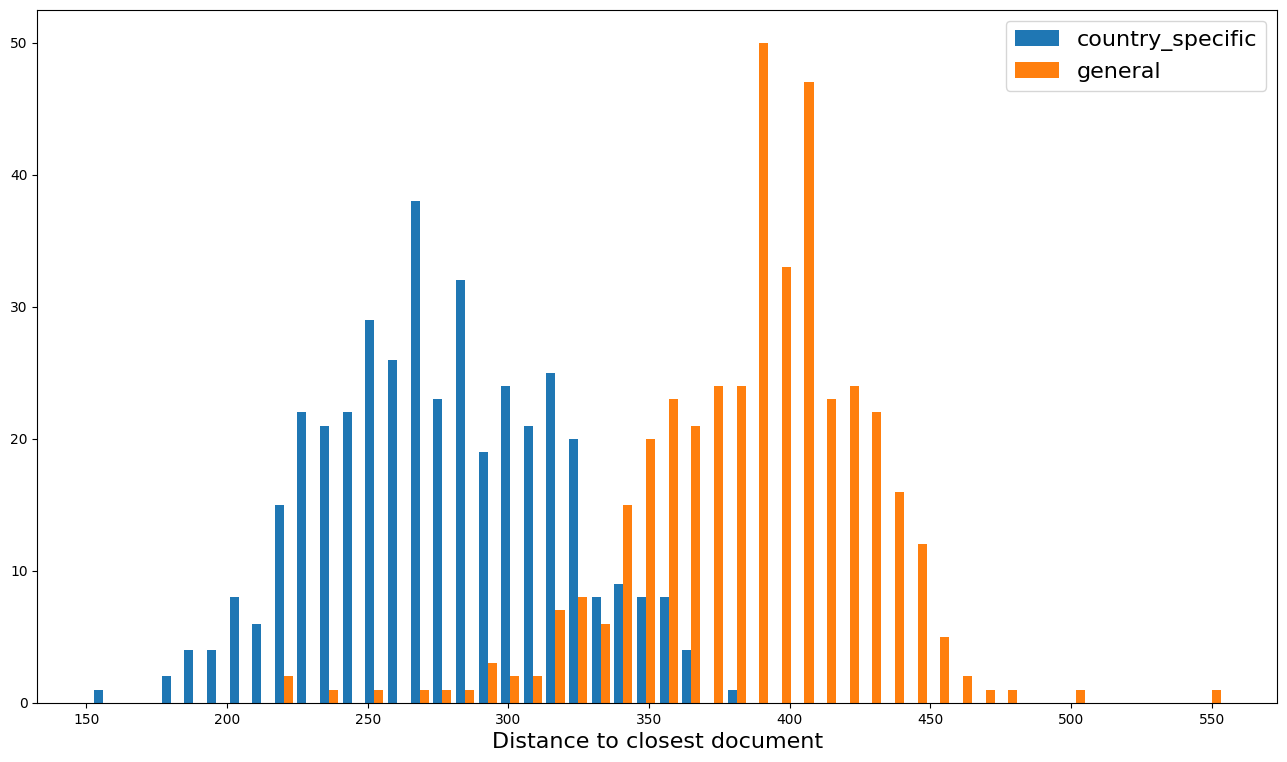

In [63]:
pl.figure(figsize=(16, 9))
pl.hist(
    [
        question_distances['country_specific'],
        question_distances['general']
    ],
    color=['tab:blue', 'tab:orange'],
    label=['country_specific', 'general'],
    bins=50
)
pl.legend(fontsize=16)
pl.legend(fontsize=16)
pl.xlabel('Distance to closest document', fontsize=16)
pl.show()

We can see the two distributions are neatly separated, so we can use a threshold to distinguish between country-specific and general questions. To find the optimal threshold we need to define a loss function that would be minimized. (1 - accuracy) will work just about well for this case given the balanced dataset.

In [66]:
def loss(threshold: float,
         distance_data: dict[str, list[float]],
         bootstrap: bool = False) -> float:
    """
    Calculates (1 - accuracy) of the question distribution for the given
    the threshold which can be minimized to get the best-separating threshold.

    :param distance_data:   data on question distance to the closest document,
                            expected format:
                                {
                                    'country_specific': [<d0: float>, <d1: float>, ...>],
                                    'general': [<d0: float>, <d1: float>, ...>]
                                }
    :param threshold:   threshold for which to calculate the loss
    :param bootstrap:   whether to perform bootstrap sampling 
                        (see: https://en.wikipedia.org/wiki/Bootstrapping_(statistics))
    :return: 
    """
    positive = np.array(distance_data['country_specific'])
    negative = np.array(distance_data['general'])

    if bootstrap:
        positive = np.random.choice(positive, size=len(positive), replace=True)
        negative = np.random.choice(negative, size=len(negative), replace=True)

    return 1 - (
            (positive <= threshold).sum() + (negative > threshold).sum()
    ) / (len(positive) + len(negative))

We can use `scipy.optimize.minimize` to find the optimal threshold. Just need to make sure the fit converges well.

In [78]:
result = minimize(
    partial(loss, distance_data=question_distances),
    x0=300,
    method='Nelder-Mead'
)

optimal_threshold = result.x[0]
accuracy = 1 - result.fun

print(f'Optimal threshold: {optimal_threshold:.2f}, accuracy: {accuracy * 100:.2f}%')

Optimal threshold: 323.44, accuracy: 93.25%


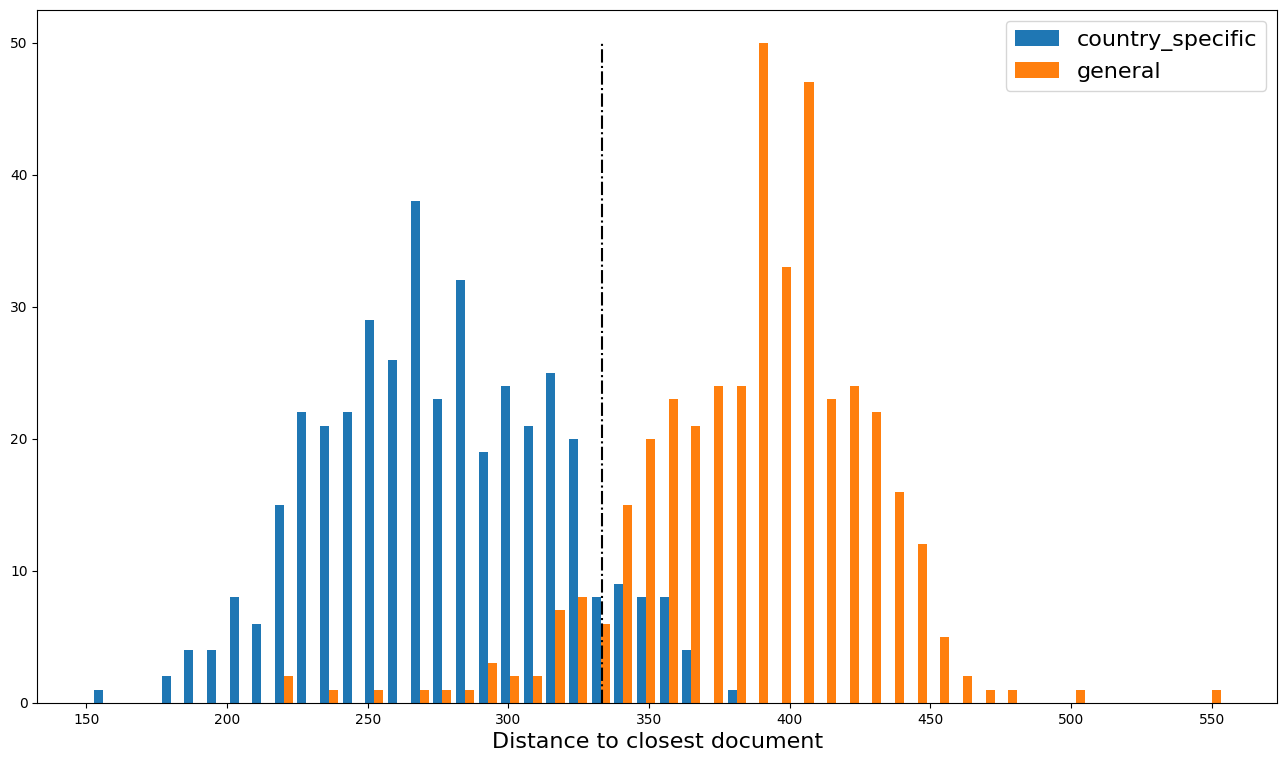

In [74]:
pl.figure(figsize=(16, 9))
counts, _, _ = pl.hist(
    [
        question_distances['country_specific'],
        question_distances['general']
    ],
    color=['tab:blue', 'tab:orange'],
    label=['country_specific', 'general'],
    bins=50
)
pl.plot(
    [optimal_threshold, optimal_threshold],
    [0, max(counts.ravel())],
    color='k',
    linestyle='dashdot'
)
pl.legend(fontsize=16)
pl.xlabel('Distance to closest document', fontsize=16)
pl.show()

Measurement without uncertainty is meaningless. As an example, if we tried to measure the width of a human hair, we'd get a solid zero. Does it mean the hair is infinitely thin? No, it just means that the measurement had been done using an instrument with accuracy of +-0.5mm, hence the real thickness is somewhere between 0 and 0.5mm (Physics rules out the negative half of the probability distribution).

Something similar applies to the above measurement of the optimal threshold. Our dataset does not contain all the possible questions in each category but should rather be thought of as a (ideally random) sample from a distribution of all possible questions.

Obviously there are many different variables which will have made it difficult to provide an accurate uncertainty estimate. Our dataset is almost certainly biased since we synthetically generated all the questions, some questions are repetitive, etc.

What we can do is to try to use the random-sample hypothesis to provide some uncertainty estimate. So let's use the boostrap method.

In [88]:
N_BOOTSTRAPS = 1000
bootstrap_thresholds, bootstrap_accuracies = [], []
for _ in range(N_BOOTSTRAPS):
    result = minimize(
        partial(loss, distance_data=question_distances, bootstrap=True),
        x0=300,
        method='Nelder-Mead'
    )
    bootstrap_thresholds.append(result.x[0])
    bootstrap_accuracies.append(1 - result.fun)
bootstrap_thresholds = np.array(bootstrap_thresholds)
bootstrap_accuracies = np.array(bootstrap_accuracies)

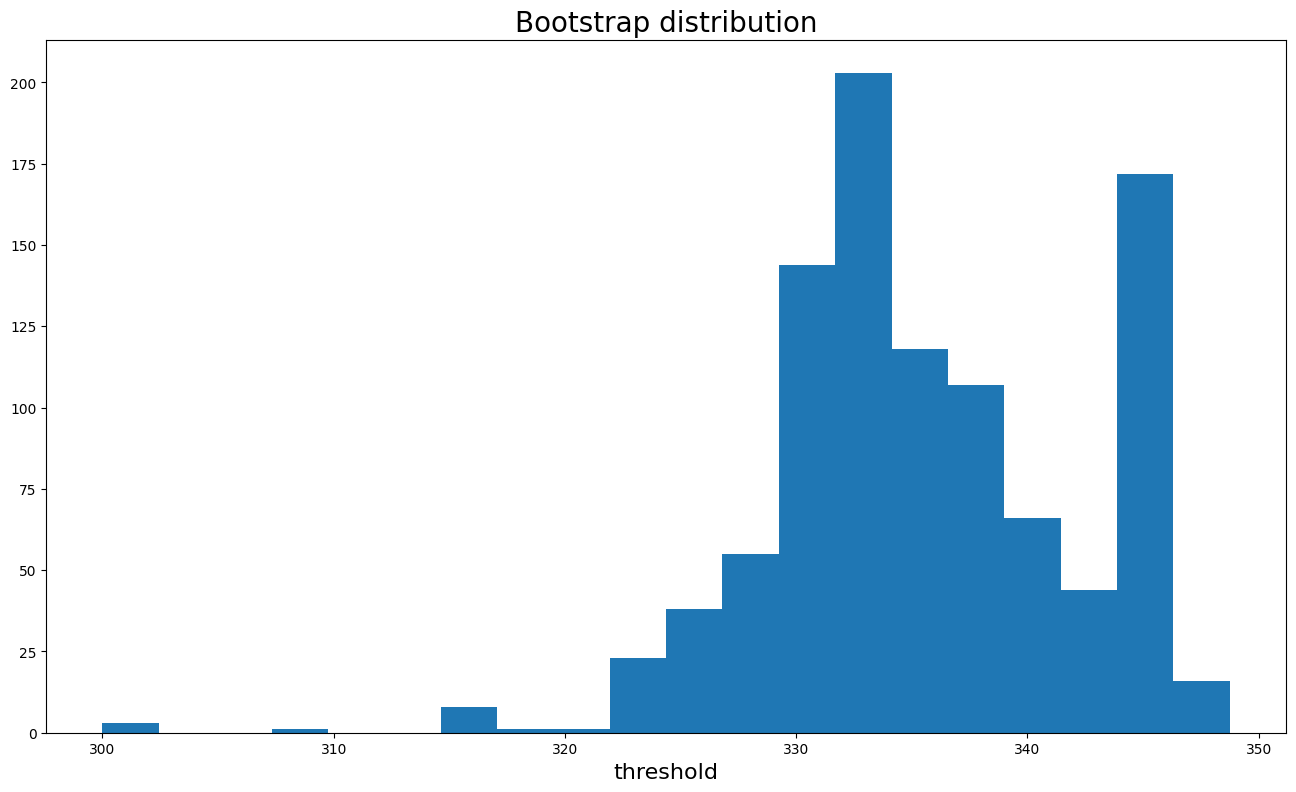

In [90]:
pl.figure(figsize=(16, 9))
pl.title('Bootstrap distribution', fontsize=20)
pl.hist(bootstrap_thresholds, bins=20)
pl.xlabel('threshold', fontsize=16)
pl.show()

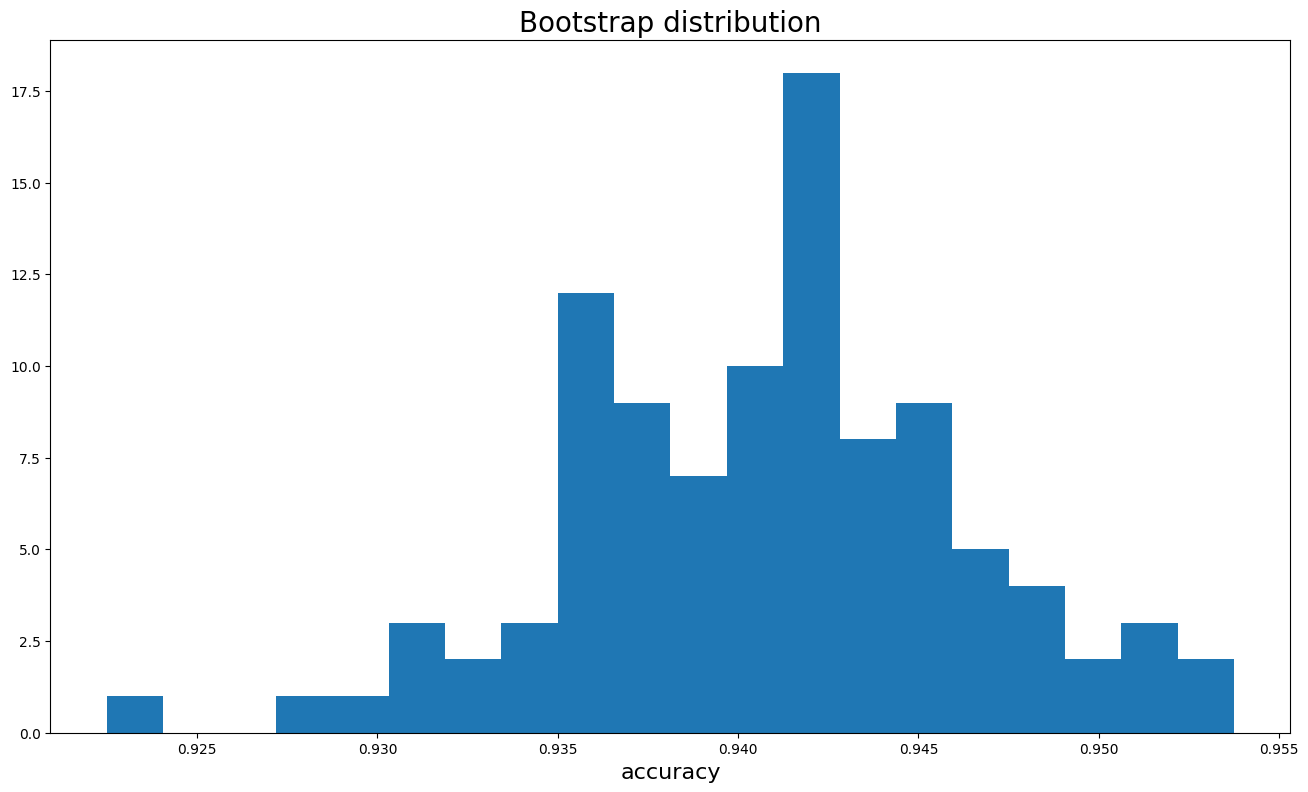

In [82]:
pl.figure(figsize=(16, 9))
pl.title('Bootstrap distribution', fontsize=20)
pl.hist(bootstrap_accuracies, bins=20)
pl.xlabel('accuracy', fontsize=16)
pl.show()

In [91]:
print('=== bootstrap results ===')
print('- threshold:')
print(
    f'    mean: {bootstrap_thresholds.mean():.2f}, std: {bootstrap_thresholds.std():.2f}')
print('- accuracy:')
print(
    f'    mean: {bootstrap_accuracies.mean() * 100:.2f}%, std: {bootstrap_accuracies.std() * 100:.2f}%')

=== bootstrap results ===
- threshold:
    mean: 335.56, std: 6.80
- accuracy:
    mean: 93.97%, std: 0.71%


## Conclusion

These results can be interpreted this way:
- Our best go on the threshold is 335
- Roughly 6% of the questions will be misclassified (resulting e.g. in the chatbot providing country-specific policy, while the question did not ask for it)
- If the ration of misclassified questions (in production over a longer period of time) rose over 8.15% (corresponding to 3 sigma deviation or just about 0.5% chance it being a random fluctuation), we'd need to get back to our analysis and update the threshold accordingly

We can use MLFlow to keep track of production results